In [1]:
"""
Dataloaders for final model
"""
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import  pad_sequence
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.pyg_reader import build_graph,global_node2idx_mapping,visualize_patient_graph,visualize_by_patient_id
from torch_geometric.data import Batch
import h5py
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from collections import defaultdict

In [2]:
class MultiModalDataset(Dataset):
    def __init__(self, data_path,global_node2idx):
        
        self.data_path = data_path
        self.ts_h5_file = os.path.join(self.data_path, 'ts_each_patient.h5')
        self.risks_h5_file = os.path.join(self.data_path, 'risk_each_patient.h5')
        self.flat_h5_file = os.path.join(self.data_path, 'flat.h5')
        self.diagnosis_h5_file = os.path.join(self.data_path, 'diagnoses_level.h5')
        
        self.ts_h5f = h5py.File(self.ts_h5_file, 'r')
        self.risk_h5f = h5py.File(self.risks_h5_file, 'r')
        self.flat_data = pd.read_hdf(self.flat_h5_file)
        self.diag_data = pd.read_hdf(self.diagnosis_h5_file)
        
        all_graphs = build_graph(self.diag_data,global_node2idx)
        self.graphs = { int(g.patient_id): g for g in all_graphs }
        
        self.patient_ids = list(self.ts_h5f.keys())

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        str_pid = self.patient_ids[idx]
        patient_id = int(str_pid) 
        
        ts_data = self.ts_h5f[str_pid][:, 1:]  # exclude the first column which is the time
        risk_data = self.risk_h5f[str_pid][:] # 
        flat_data = self.flat_data.loc[int(patient_id)].values
       
        category = int(risk_data[0][5])  # discharge_risk_category
        mortality_label = int(risk_data[0][4])  # unitdischargestatus
        
        ## get the graph data
        graph_data = self.graphs[patient_id]
        
        ## convert to torch tensors
        ts_data = torch.tensor(ts_data, dtype=torch.float32)
        flat_data = torch.tensor(flat_data, dtype=torch.float32)
        risk_data = torch.tensor(risk_data[:,-1], dtype=torch.float32) # risk data is the last column
        cat   = torch.tensor(category,        dtype=torch.long)
        mort  = torch.tensor(mortality_label, dtype=torch.long)
        
        return patient_id, flat_data,ts_data, graph_data,risk_data, cat, mort

    def close(self):
        self.ts_h5f.close()
        self.risk_h5f.close()

 
    
def collate_fn(batch):
    patient_ids,  flat_list,ts_list, graphs, risk_list,category_list,mortality_labels = zip(*batch)
    
    lengths = [x.shape[0] for x in ts_list]
    lengths = torch.tensor(lengths, dtype=torch.long)

    # order by length
    lengths, sorted_idx = torch.sort(lengths, descending=True)
    ts_list = [ts_list[i] for i in sorted_idx]
    risk_list = [risk_list[i] for i in sorted_idx]
    flat_list = [flat_list[i] for i in sorted_idx]
    patient_ids = [patient_ids[i] for i in sorted_idx]
    category_list = [category_list[i] for i in sorted_idx]
    mortality_labels = [mortality_labels[i] for i in sorted_idx]
    
    # pad sequences
    padding_value = 0
    padded_ts = pad_sequence(ts_list, batch_first=True, padding_value=padding_value)
    padded_risk = pad_sequence(risk_list, batch_first=True, padding_value=padding_value)
    flat_data = torch.stack(flat_list)
    categories = torch.tensor(category_list, dtype=torch.long)
    mortality_labels = torch.tensor(mortality_labels, dtype=torch.long)
    
    graphs_batch = Batch.from_data_list([graphs[i] for i in sorted_idx])
    
    
    return patient_ids,  flat_data, padded_ts, graphs_batch ,padded_risk, lengths,categories, mortality_labels


In [3]:
data_path="/home/mei/nas/docker/thesis/data/hdf/test"
hdf = '/home/mei/nas/docker/thesis/data/hdf/'

train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses_level.h5',key='df')
global_node2idx = global_node2idx_mapping(train_diagnoses)

dataset = MultiModalDataset(data_path,global_node2idx)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

Built 461 patient-tree graphs


In [4]:
for pid, flat, ts, graph_batch, risk, lengths, cats, morts in dataloader:
    print("patient_ids:", pid)             # list of int
    print("flat shape:", flat.shape)       # (B, D_flat)
    print("ts shape:", ts.shape)           # (B, T_max, D_ts)
    print("risk shape:", risk.shape)       # (B, T_max)
    print("lengths:", lengths)             # (B,)
    print("categories:", cats)             # (B,)
    print("mortality labels:", morts)      # (B,)
    print("graph batch.x:", graph_batch.x.shape)           # (sum_Nodes, feat)
    print("graph batch.edge_index:", graph_batch.edge_index.shape)
    for i, pid in enumerate(pid):
       node_count  =(graph_batch.batch== i).sum().item()
       print(f"patient id: {pid}, node count: {node_count}")
    break

patient_ids: [2754168, 1822777]
flat shape: torch.Size([2, 104])
ts shape: torch.Size([2, 1206, 154])
risk shape: torch.Size([2, 1206])
lengths: tensor([1206,  286])
categories: tensor([1, 0])
mortality labels: tensor([0, 0])
graph batch.x: torch.Size([6, 62])
graph batch.edge_index: torch.Size([2, 8])
patient id: 2754168, node count: 2
patient id: 1822777, node count: 4


In [5]:
ts_h5_file = os.path.join(data_path, 'ts_each_patient.h5')
with h5py.File(ts_h5_file, 'r') as f:
    ts_data = {key: np.array(f[key]) for key in f.keys()}

risks_h5_file = os.path.join(data_path, 'risk_each_patient.h5')
with h5py.File(risks_h5_file, 'r') as f:
    risk_data = {key: np.array(f[key]) for key in f.keys()}


In [6]:
patient_id = '2754168' 
if patient_id in ts_data:
    ts_series = ts_data[patient_id]
    print(f"Time series length for patient {patient_id}: {len(ts_series)}")
    
if patient_id in risk_data:
    risk_series = risk_data[patient_id]
    categories = risk_series[:, 5]
    mortality_labels = risk_series[:, 4]
    print(f"Risk categories for patient {patient_id}: {categories}")
    print(f"Mortality labels for patient {patient_id}: {mortality_labels}")
    print(f"Risk series length for patient {patient_id}: {len(risk_series)}")

Time series length for patient 2754168: 1206
Risk categories for patient 2754168: [1. 1. 1. ... 1. 1. 1.]
Mortality labels for patient 2754168: [0. 0. 0. ... 0. 0. 0.]
Risk series length for patient 2754168: 1206


In [7]:
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
test_diagnoses = pd.read_hdf(f'{hdf}test/diagnoses_level.h5',key='df')

test_graph = build_graph(test_diagnoses,global_node2idx)

Built 461 patient-tree graphs


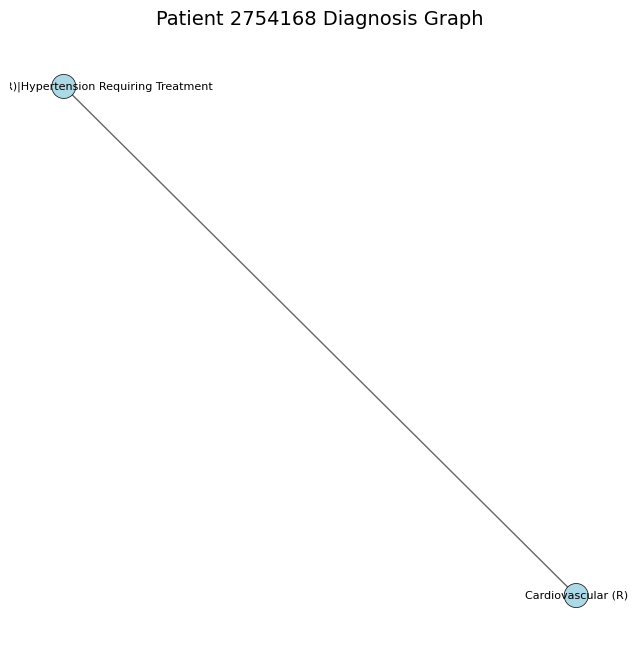

In [8]:
visualize_by_patient_id(test_graph,2754168, k=1.5, figsize=(8,8))

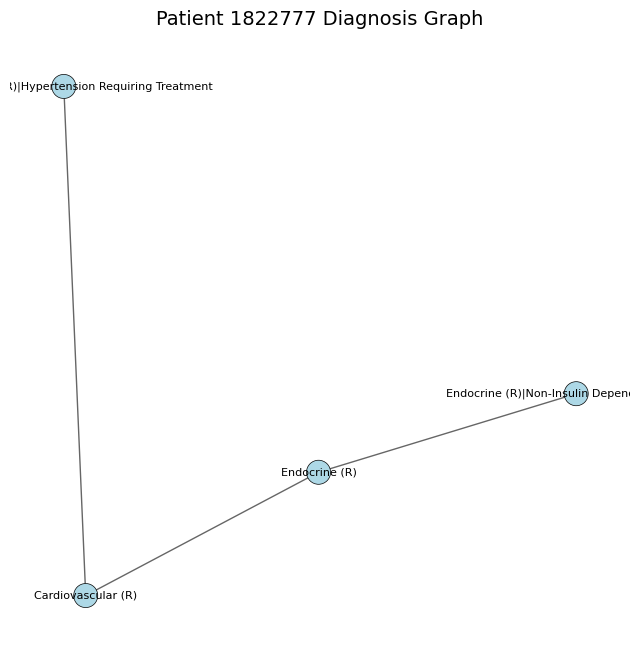

In [9]:
visualize_by_patient_id(test_graph,1822777, k=1.3, figsize=(8,8))

In [10]:
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
test_diagnoses = pd.read_hdf(f'{hdf}test/diagnoses_level.h5',key='df')

In [13]:
id = 2754168
info = test_diagnoses.loc[id]
info

diagnosisstring     Cardiovascular (R)/Hypertension Requiring Tre...
first                                             Cardiovascular (R)
second                              Hypertension Requiring Treatment
Name: 2754168, dtype: object

In [14]:
id = 1822777
info2 = test_diagnoses.loc[id]
info2

,diagnosisstring,first,second
patient,,,
1822777,Cardiovascular (R)/Hypertension Requiring Tre...,Cardiovascular (R),Hypertension Requiring Treatment
1822777,Endocrine (R)/Non-Insulin Dependent Diabetes,Endocrine (R),Non-Insulin Dependent Diabetes
